In [4]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve,
                             precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

d:\CreditCard_FraudDetection\cenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 2) Load data
# expects 'creditcard.csv' with 'Class' column (0=legit, 1=fraud)
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print("Shape:", df.shape)

Shape: (284807, 31)


In [7]:
print(df['Class'].value_counts(normalize=True))


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

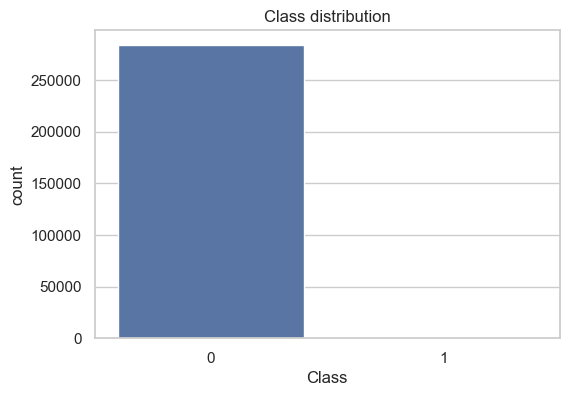

In [9]:
# 3 Exploratory Data Analysis (EDA)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class distribution")
plt.show()

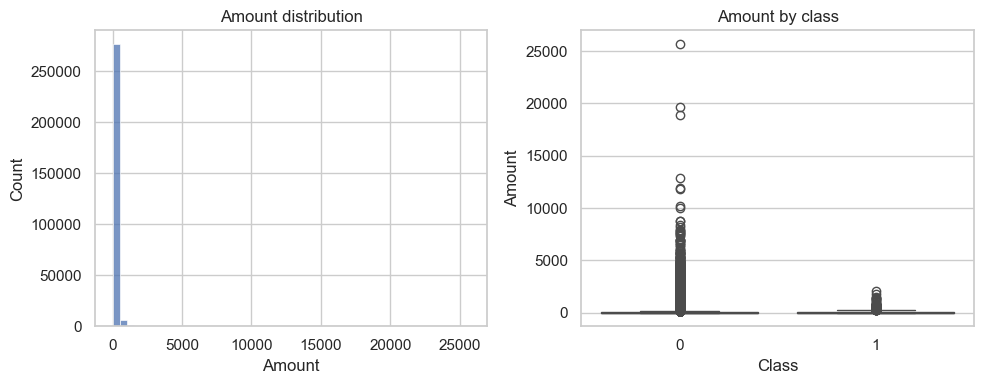

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['Amount'], bins=50)
plt.title("Amount distribution")
plt.subplot(1,2,2)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Amount by class")
plt.tight_layout()
plt.show()

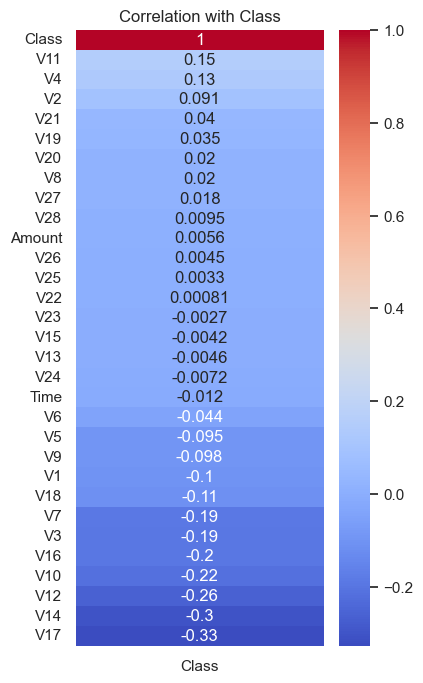

In [11]:
# Optional: correlation with Class
corr = df.corr()
plt.figure(figsize=(4,8))
sns.heatmap(corr[['Class']].sort_values('Class', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Class")
plt.show()

In [12]:
# 4) Preprocessing: scaling Amount & Time 
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

In [13]:
scaler = StandardScaler()
if 'Amount' in X.columns:
    X['Amount_scaled'] = scaler.fit_transform(X[['Amount']])
    X = X.drop(columns=['Amount'])
if 'Time' in X.columns:
    X['Time_scaled'] = scaler.fit_transform(X[['Time']])
    X = X.drop(columns=['Time'])

print("Features:", X.columns.tolist()[:10])

Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']


In [14]:
# 5) Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train class dist:", y_train.value_counts(normalize=True).to_dict())


Train size: (227845, 30) Test size: (56962, 30)
Train class dist: {0: 0.9982707542408216, 1: 0.001729245759178389}


In [15]:
# Helper eval function
def evaluate_probs(probs, y_true, threshold=0.5, plot_pr=False, plot_roc=False, name=None):
    preds = (probs >= threshold).astype(int)
    print(f"--- {name or ''} (thr={threshold:.3f}) ---")
    print(classification_report(y_true, preds, digits=4))
    print("ROC AUC:", roc_auc_score(y_true, probs))
    print("PR AUC (avg precision):", average_precision_score(y_true, probs))
    if plot_pr:
        p, r, t = precision_recall_curve(y_true, probs)
        plt.figure(figsize=(6,4))
        plt.plot(r, p, label=f'PR curve (AP={average_precision_score(y_true,probs):.4f})')
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.legend(); plt.show()
    if plot_roc:
        fpr, tpr, _ = roc_curve(y_true, probs)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true,probs):.4f})')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()
    return preds


--- Logistic (balanced) (thr=0.500) ---
              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962

ROC AUC: 0.9720948047902335
PR AUC (avg precision): 0.7189348125855011


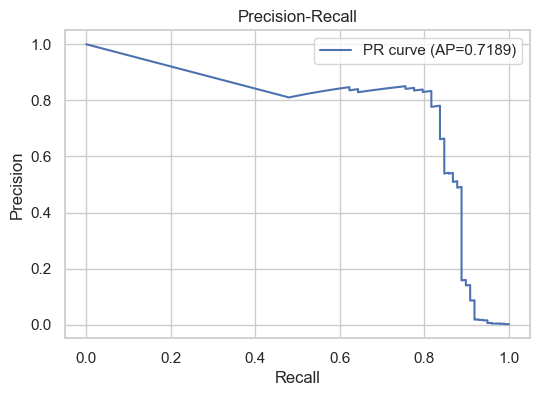

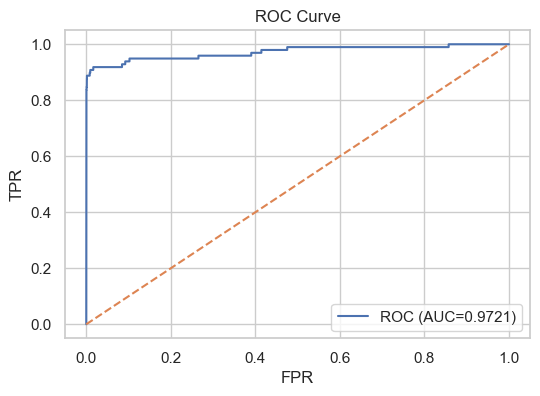

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
# 6) Baseline: Logistic Regression (class_weight='balanced')
lr = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:,1]
evaluate_probs(lr_probs, y_test, threshold=0.5, plot_pr=True, plot_roc=True, name="Logistic (balanced)")

--- RandomForest (balanced) (thr=0.500) ---
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56864
           1     0.9474    0.7347    0.8276        98

    accuracy                         0.9995     56962
   macro avg     0.9735    0.8673    0.9137     56962
weighted avg     0.9995    0.9995    0.9994     56962

ROC AUC: 0.9574628652108
PR AUC (avg precision): 0.862393762672678


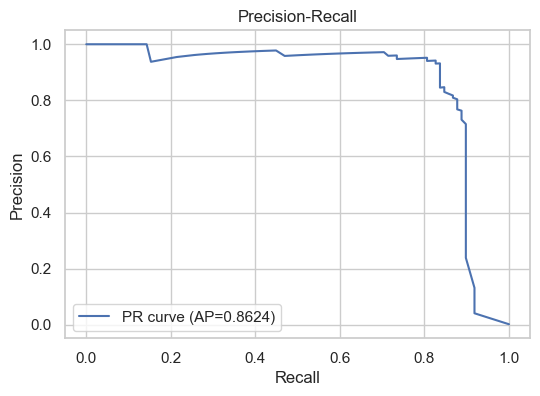

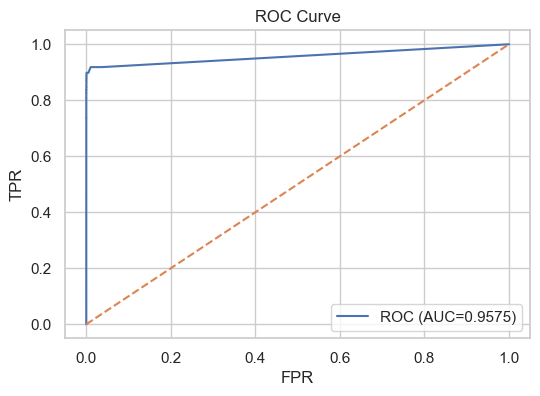

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
##7) Random Forest (class_weight='balanced')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:,1]
evaluate_probs(rf_probs, y_test, threshold=0.5, plot_pr=True, plot_roc=True, name="RandomForest (balanced)")


--- SMOTE+RF (thr=0.500) ---
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8723    0.8367    0.8542        98

    accuracy                         0.9995     56962
   macro avg     0.9360    0.9183    0.9270     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC AUC: 0.9704325860197764
PR AUC (avg precision): 0.8823343200777349


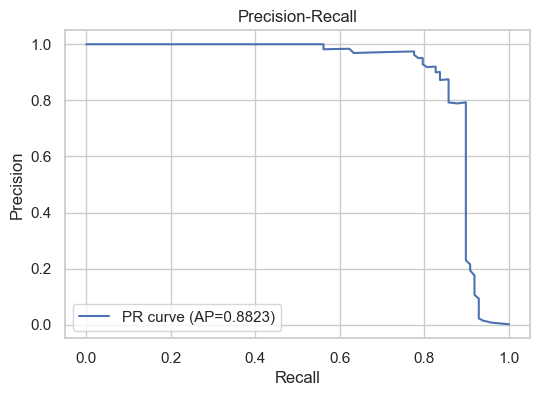

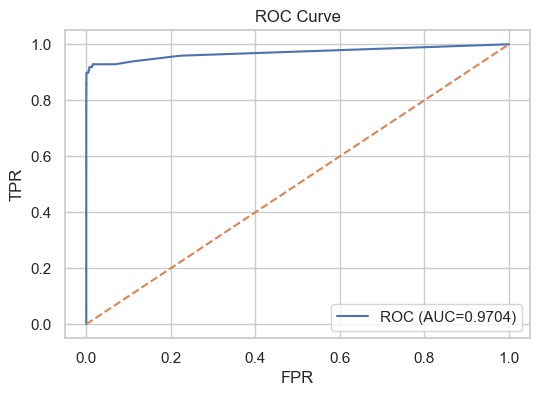

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
# 8) SMOTE + RandomForest (apply SMOTE only on train using pipeline)
smote = SMOTE(random_state=42, sampling_strategy=0.2)  # tune sampling_strategy
rf2 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
pipeline = ImbPipeline([("smote", smote), ("rf", rf2)])
pipeline.fit(X_train, y_train)
pipe_probs = pipeline.predict_proba(X_test)[:,1]
evaluate_probs(pipe_probs, y_test, threshold=0.5, plot_pr=True, plot_roc=True, name="SMOTE+RF")


Best threshold (max F1 on test): 0.63 F1: 0.8709677414369291
--- SMOTE+RF (tuned thr=0.630) (thr=0.630) ---
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9205    0.8265    0.8710        98

    accuracy                         0.9996     56962
   macro avg     0.9601    0.9132    0.9354     56962
weighted avg     0.9996    0.9996    0.9996     56962

ROC AUC: 0.9704325860197764
PR AUC (avg precision): 0.8823343200777349


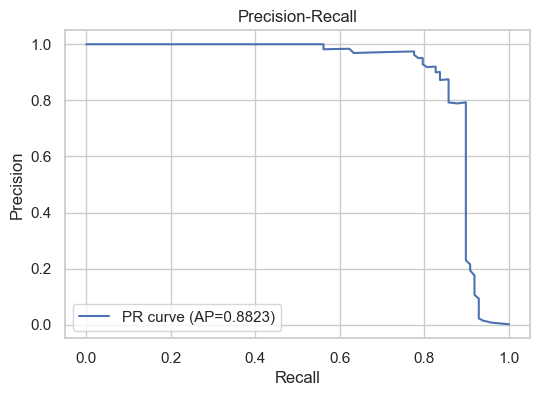

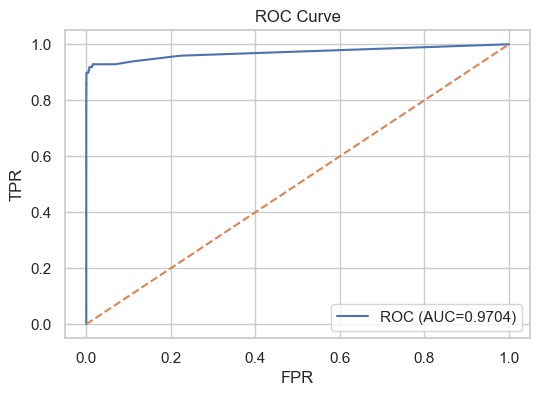

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
# 9) Threshold tuning (choosing threshold maximizing F1 or business metric on validation)
# Here we use test set for demonstration; in practice use a validation set/CV
prec, rec, thr = precision_recall_curve(y_test, pipe_probs)
f1 = 2*prec*rec/(prec+rec+1e-9)
best_idx = np.nanargmax(f1[:-1])  # last threshold-less pair ignored
best_thr = thr[best_idx]
print("Best threshold (max F1 on test):", best_thr, "F1:", f1[best_idx])
evaluate_probs(pipe_probs, y_test, threshold=best_thr, plot_pr=True, plot_roc=True, name=f"SMOTE+RF (tuned thr={best_thr:.3f})")


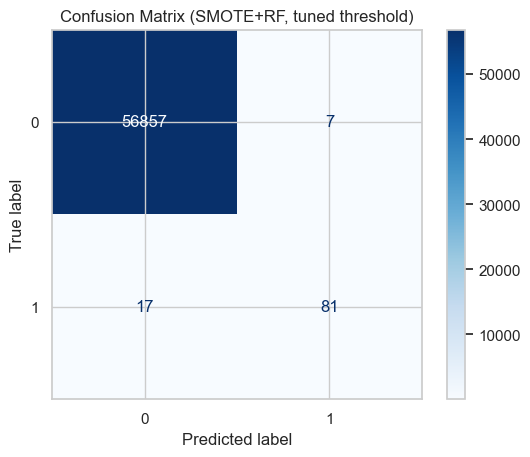

In [25]:
# 10) Confusion matrix at chosen threshold
from sklearn.metrics import ConfusionMatrixDisplay
best_preds = (pipe_probs >= best_thr).astype(int)
cm = confusion_matrix(y_test, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (SMOTE+RF, tuned threshold)")
plt.show()

V14              0.197979
V17              0.141004
V10              0.137266
V12              0.075374
V11              0.073086
V3               0.062480
V4               0.055452
V16              0.052722
V7               0.029385
V2               0.018832
V9               0.016058
V21              0.012827
V18              0.012739
V27              0.012166
V6               0.008904
V19              0.008303
V13              0.007961
V8               0.007760
V5               0.007615
V1               0.007610
Amount_scaled    0.007251
V26              0.007060
V20              0.006274
V28              0.005963
Time_scaled      0.005534
V15              0.005383
V25              0.004416
V23              0.004407
V22              0.004224
V24              0.003966
dtype: float64

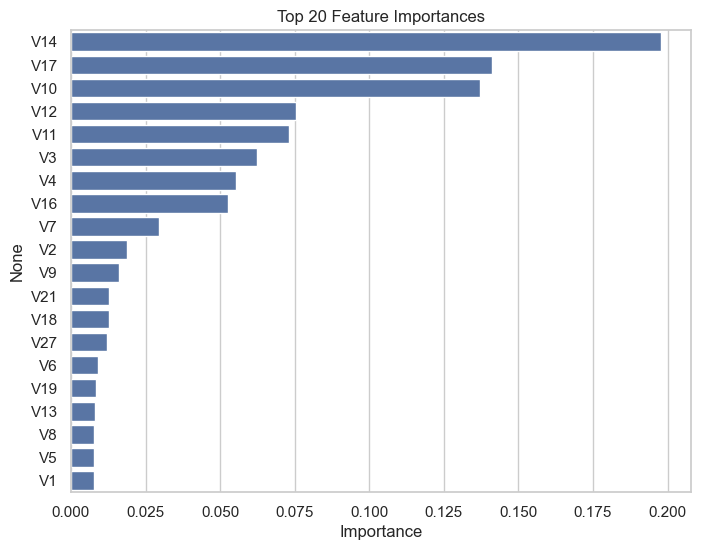

In [26]:
# 11) Feature importance (from RF inside pipeline)
# If using pipeline, extract the RF
rf_model = pipeline.named_steps['rf'] if hasattr(pipeline, 'named_steps') else rf
importances = rf_model.feature_importances_
fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
display(fi.head(30))
plt.figure(figsize=(8,6))
sns.barplot(x=fi.head(20).values, y=fi.head(20).index)
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()

In [27]:
# 13) Model comparison table (metrics)
def gather_metrics(name, probs, y_true, threshold=0.5):
    preds = (probs >= threshold).astype(int)
    return {
        "model": name,
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall": recall_score(y_true, preds),
        "f1": f1_score(y_true, preds),
        "roc_auc": roc_auc_score(y_true, probs),
        "avg_precision": average_precision_score(y_true, probs)
    }

rows = []
rows.append(gather_metrics("Logistic (balanced)", lr_probs, y_test, threshold=0.5))
rows.append(gather_metrics("RF (balanced)", rf_probs, y_test, threshold=0.5))
rows.append(gather_metrics(f"SMOTE+RF (thr={best_thr:.3f})", pipe_probs, y_test, threshold=best_thr))
comp = pd.DataFrame(rows).set_index("model").sort_values("f1", ascending=False)
display(comp)

,precision,recall,f1,roc_auc,avg_precision
model,,,,,
SMOTE+RF (thr=0.630),0.920455,0.826531,0.870968,0.970433,0.882334
RF (balanced),0.947368,0.734694,0.827586,0.957463,0.862394
Logistic (balanced),0.060976,0.918367,0.114358,0.972095,0.718935


In [28]:
import joblib

to_save = {
    "model": pipeline,            # your fitted pipeline / estimator
    "type": "smote_rf",           # optional meta
    "threshold": float(best_thr)  # optional
}
joblib.dump(to_save, "best_fraud_pipeline.joblib")
print("Saved normalized object to best_fraud_pipeline.joblib")


Saved normalized object to best_fraud_pipeline.joblib
